# Design Validation Plates

We want to design 4 plates for experimental validation

## "cherry-picking plate"
One plate containing 320 compounds.
Design Process:
1. Select 15 representative Initiators, 15 representative Monomers and 10 representative Terminators
2. Filter out any known combinations
3. Let the model predict reaction outcome and remove all combinations where the predicted reaction outcome is negative
4. Randomly select 320 of the remaining compounds
5. Design source plate and transfer files for this plate

## "extrapolation plates"
Three plates of 320 compounds each for a total of 960 compounds
12 I x 10 M x 8 T
We have identified 12 previously unused Initiators
Design process:
1. Select 10 representative Monomers and 8 representative Terminators
2. We will use a full factorial design and only need to design the appropriate source plate and transfer files


In [17]:
import pathlib
import sys

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw,rdMolDescriptors,AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit import SimDivFilters,DataStructs
import 

sys.path.append(str(pathlib.Path().resolve().parents[1]))
from src.util.db_utils import SynFermDatabaseConnection

In [2]:
con = SynFermDatabaseConnection()

In [5]:
res = con.con.execute("SELECT * FROM building_blocks").fetchall()
header = [i[1] for i in con.con.execute("PRAGMA table_info(building_blocks)").fetchall()]
df = pd.DataFrame(res, columns=header)
initiators = df.loc[df["category"] == "I"]
monomers = df.loc[df["category"] == "M"]
terminators = df.loc[df["category"] == "T"]

## Idea 1: RDKit's MinMaxPicker

In [36]:
mols = [Chem.MolFromSmiles(smi) for smi in terminators["SMILES"]]

fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m,2) for m in mols]

In [42]:
# https://rdkit.blogspot.com/2014/08/optimizing-diversity-picking-in-rdkit.html
def dmat_sim(fps,ntopick):
    ds=[]
    for i in range(1,len(fps)):
         ds.extend(DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i],returnDistance=True))
    mmp =SimDivFilters.MaxMinPicker()
    ids=mmp.Pick(np.array(ds),len(fps),ntopick)
    return ids

dmat_ids=dmat_sim(fps, 10)

Draw.MolsToGridImage([mols[x] for x in dmat_ids],molsPerRow=5, subImgSize=(300,300))

### Idea 1 conclusion
Due to how the MinMaxPicker works we sample the "weirdest" compounds, the ones most disparate from each other and thus our data set. This does not make sense when we want representative compounds

## Idea 2: Random picking


In [272]:
# still need to filter to only have the ones that were not excluded during data analysis
experiments = con.get_experiments_table_as_df()

In [288]:
valid_exp = experiments.loc[(~experiments["valid"].str.contains("ERROR", na=False)) & (experiments["exp_nr"].between(4,29))]
valid_ini = set(valid_exp["initiator_long"].to_numpy().tolist())
valid_mon = set(valid_exp["monomer_long"].to_numpy().tolist())
valid_ter = set(valid_exp["terminator_long"].to_numpy().tolist())

len(valid_ini), len(valid_mon), len(valid_ter)

(67, 72, 41)

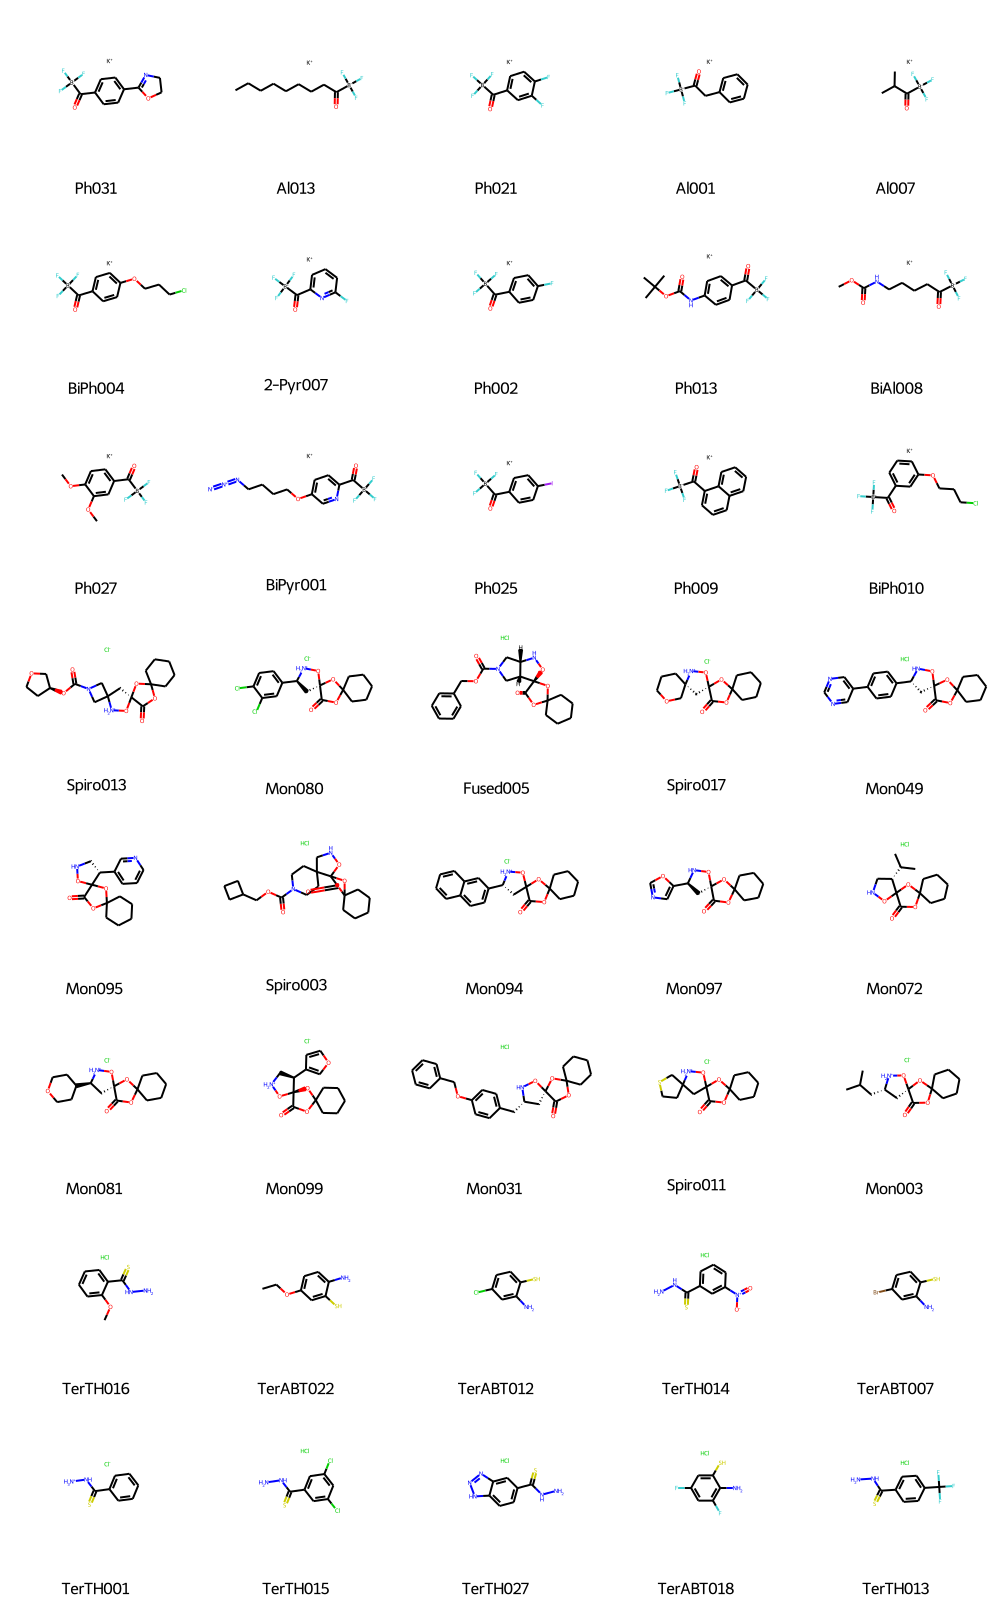

In [295]:
# draw randomly?
select_ini = initiators.loc[initiators["long"].isin(valid_ini)].sample(11, random_state=1)
select_mon = monomers.loc[monomers["long"].isin(valid_mon)].sample(15, random_state=2)
select_ter = terminators.loc[terminators["long"].isin(valid_ter)].sample(10, random_state=3)

selected = pd.concat((select_ini, select_mon, select_ter))

Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in selected["SMILES"]], legends=selected["long"].to_numpy().tolist(), molsPerRow=5)


In [308]:
# from these, we remove all combinations where we attempted synthesis
products = [f"{i} + {j} + {k}" for i in select_ini["long"] for j in select_mon["long"] for k in select_ter["long"]]
len(products)

In [310]:
attempted = experiments.loc[experiments["exp_nr"].between(4,29), "long_name"].to_numpy().tolist()
not_attempted = [p for p in products if p not in attempted]
len(not_attempted)

In [322]:
# for all the not attempted ones, write a file with the following columns:
# idx, vl_id, long_name, reaction_SMILES_atom_mapped
vl_ids, smiles = [], []
for long in not_attempted:
    res = con.con.execute("SELECT id, SMILES FROM virtuallibrary WHERE long_name IN (?) AND type = 'A';", (long,)).fetchall()
    assert len(res) == 1
    vl_ids.append(res[0][0])
    smiles.append(res[0][1])

In [325]:
pd.DataFrame({"vl_id": vl_ids, "long_name": long, "product_A_smiles": smiles})

,vl_id,long_name,product_A_smiles
0,224342,BiPh010 + Mon003 + TerABT018,COc1ccccc1-c1nnc(CC2(NC(=O)c3ccc(C4=NCCO4)cc3)...
1,224328,BiPh010 + Mon003 + TerABT018,CCOc1ccc2nc(CC3(NC(=O)c4ccc(C5=NCCO5)cc4)CN(C(...
2,224321,BiPh010 + Mon003 + TerABT018,O=C(NC1(Cc2nc3cc(Cl)ccc3s2)CN(C(=O)O[C@H]2CCOC...
3,224341,BiPh010 + Mon003 + TerABT018,O=C(NC1(Cc2nnc(-c3cc(Cl)cc(Cl)c3)s2)CN(C(=O)O[...
4,224351,BiPh010 + Mon003 + TerABT018,O=C(NC1(Cc2nnc(-c3ccc4[nH]nnc4c3)s2)CN(C(=O)O[...
...,...,...,...
1642,136969,BiPh010 + Mon003 + TerABT018,CC(C)C[C@@H](Cc1nnc(-c2cccc([N+](=O)[O-])c2)s1...
1643,136945,BiPh010 + Mon003 + TerABT018,CC(C)C[C@@H](Cc1nc2cc(Br)ccc2s1)NC(=O)c1cccc(O...
1644,136959,BiPh010 + Mon003 + TerABT018,CC(C)C[C@@H](Cc1nnc(-c2ccccc2)s1)NC(=O)c1cccc(...
1645,136970,BiPh010 + Mon003 + TerABT018,CC(C)C[C@@H](Cc1nnc(-c2cc(Cl)cc(Cl)c2)s1)NC(=O...
